This notebook contains the source code for salty. Usage examples are below

<a id='top'></a>

# Contents

[usage cases](#usage)

[load datasets](#load datasets)

[create histogram of selected features](#histogram)

[train lasso](#lasso)

[train multi-layer perceptron (MLP) regressor](#nn)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
%matplotlib inline

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }
plt.rcParams.update(params)
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

#grab our checkName code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import salty

<a id='usage'></a>

# Usage cases

[back to top](#top)

In [8]:
alpha_array=np.arange(0.1,0,-1e-2)
avg, std, results = validationWrapper(name_of_pickle="visc_centered_scaled_alltemps", \
            BSF=0.8, alpha_array=alpha_array, iterations=\
            3, invisible_test=False, method="cv")

performing iteration 1 of 3
running cross validation
Job will perform 10 tests for lambda
Job complete
performing iteration 2 of 3
running cross validation
Job will perform 10 tests for lambda
Job complete
performing iteration 3 of 3
running cross validation
Job will perform 10 tests for lambda
Job complete


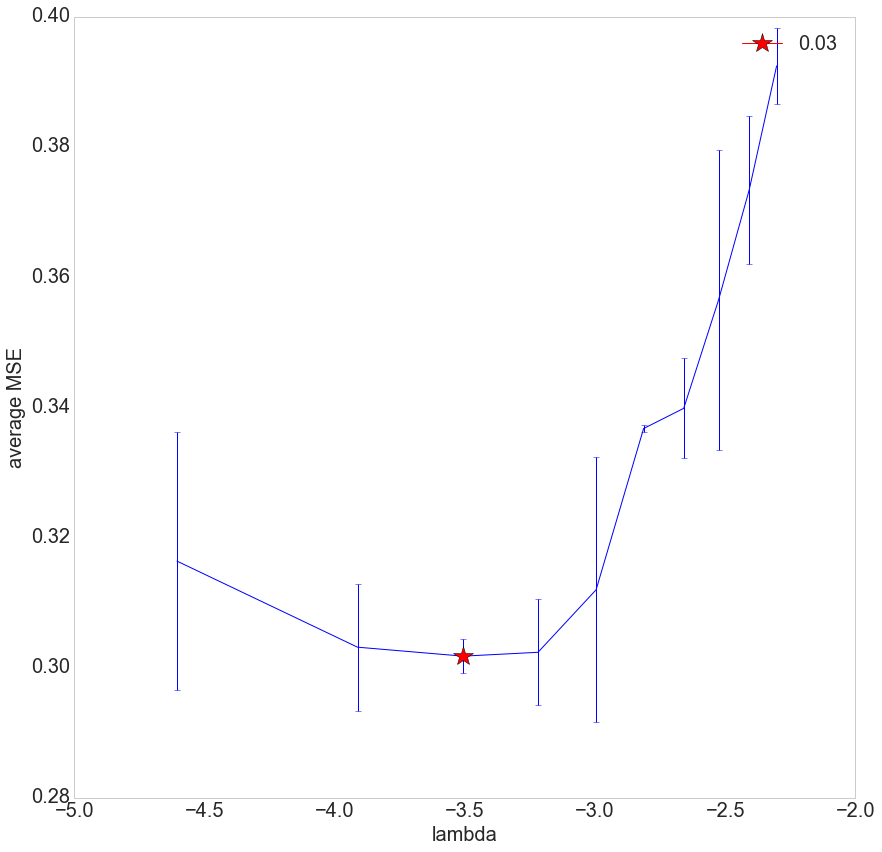

In [9]:
salty.displayResult(alpha_array, avg, variances=std, error=True)

<a id='load datasets'></a>

# Load datasets

[back to top](#top)

In [38]:
datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)
atadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 
# datadf = datadf.loc[datadf["NAME_CAT"] != "1-ethyl-3-methylimidazolium"] #create subset

datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
datadf = datadf.drop("salt_name",1)

data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8)
n_test  = n - n_train

data = np.random.permutation(data)

X_train = np.zeros((n_train,d))
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))

X_train[:] = data[:n_train,:-1]
Y_train[:] = np.log(data[:n_train,-1])

X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1])

print(X_train.shape)
print(X_test.shape)

<a id='histogram'></a>

# Create histogram of selected features using optimized LASSO

[back to top](#top)

In [3]:
datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)
atadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 
# datadf = datadf.loc[datadf["NAME_CAT"] != "1-ethyl-3-methylimidazolium"] #create subset

datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
datadf = datadf.drop("salt_name",1)

data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

deslist=datadf.columns
score=np.zeros(len(datadf.columns))
test_MSE_array=[]

for i in range(1000):
    data = np.random.permutation(data) #if you delete, will not be random ie separate by group
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = np.log(data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1].astype(float))

    ###Train the LASSO model
    model = Lasso(alpha=0.001,tol=1e-10,max_iter=2000)
    model.fit(X_train,Y_train)

    ###Check what features are selected
    i=0
    avg_size=[]
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            score[a] = score[a] + 1
            i+=1
    avg_size.append(i)
    
    ###Calculate the test set MSE
    Y_hat =model.predict(X_test)
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    test_MSE_array.append(test_MSE)
    
print(np.average(avg_size))
print(np.average(test_MSE_array))
select_score=[]
select_deslist=[]
for a in range(len(deslist)):
    if score[a] != 0:
        select_score.append(score[a])
        select_deslist.append(deslist[a])

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


36.0
0.000277728336046


imidazolium scores: 0.09798 and 22 avg. selected

all salts scores: 0.0002777 36 avg. selected

In [2]:
13./3

4.333333333333333

In [4]:
np.save("LASSOSelectionScoresAllSalts", select_score)
np.save("LASSOSelectionListAllSalts", select_deslist)

In [5]:
df = pd.DataFrame(select_score, select_deslist)
df.sort_values(by=0, ascending=False)

,0
BertzCT-cation,1000.0
HeavyAtomMolWt-anion,1000.0
Temperature_K,1000.0
VSA_EState9-anion,1000.0
VSA_EState8-anion,1000.0
EState_VSA10-anion,1000.0
EState_VSA9-anion,1000.0
EState_VSA4-anion,1000.0
SlogP_VSA6-anion,1000.0
SlogP_VSA4-anion,1000.0


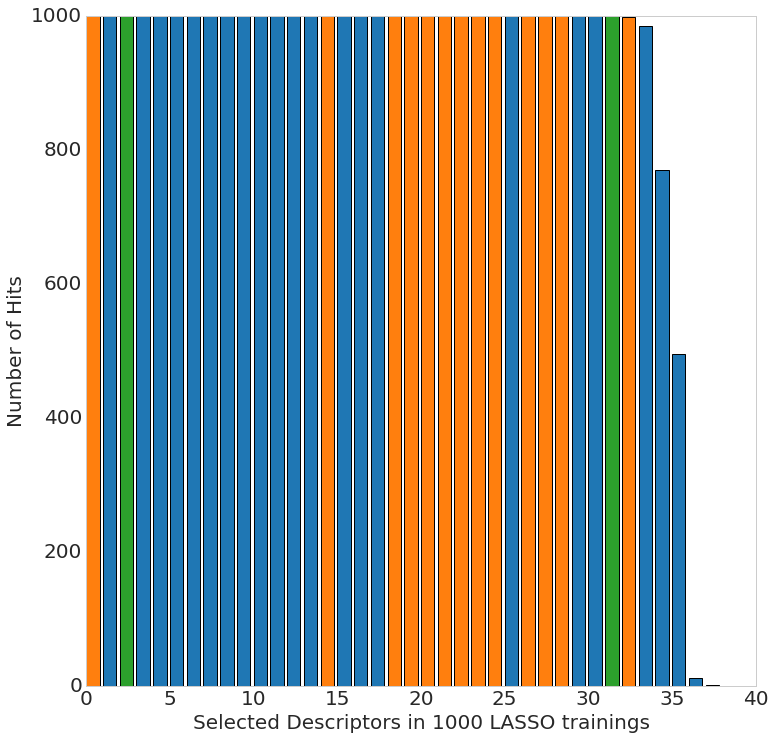

In [6]:
select_score = np.load("LASSOSelectionScoresAllSalts.npy")
select_deslist = np.load("LASSOSelectionListAllSalts.npy")
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False)
fig=plt.figure(figsize=(12,12), dpi=300)
colors=[]
for i in range(len(df)):
    try:
        if df.index[i].split("-")[1] == "anion":
            colors.append(tableau20[0])
        else:
            colors.append(tableau20[2])
    except:
        colors.append(tableau20[4]) #logT and P will throw-off assignment

with plt.style.context('seaborn-whitegrid'):
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(select_score)),df.iloc[:][0],label=select_deslist,color=colors)
    plt.grid(False)
    plt.xlabel('Selected Descriptors in 1000 LASSO trainings')
    plt.ylabel('Number of Hits')
fig.savefig(filename='../webapp/salty_web_app/collection/static/images/largeHistogramAllSalts.eps', bbox_inches='tight', format='eps')   

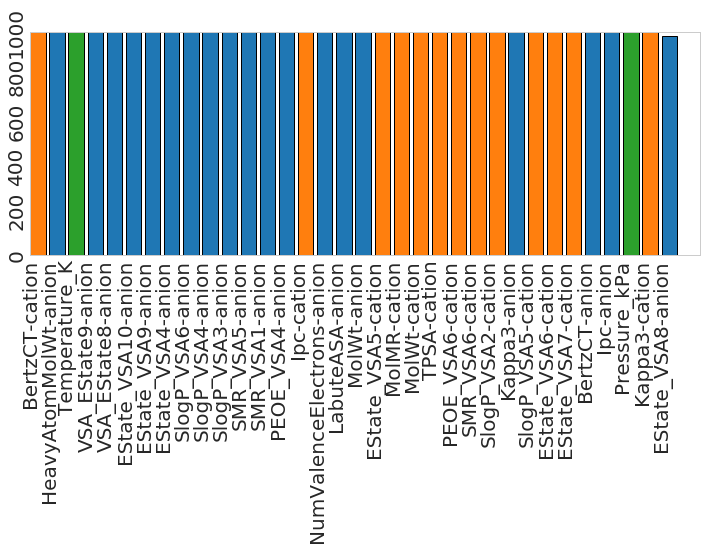

In [9]:
fig=plt.figure(figsize=(12,4), dpi=300)
avg_selected_features=34

colors=[]
for i in range(len(df[:avg_selected_features])):
    try:
        if df.index[i].split("-")[1] == "anion":
            colors.append(tableau20[0])
        else:
            colors.append(tableau20[2])
    except:
        colors.append(tableau20[4]) #logT and P will throw-off assignment

with plt.style.context('seaborn-whitegrid'):
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(select_score[:avg_selected_features])),df.iloc[:avg_selected_features]\
           [0],tick_label=df.iloc[:avg_selected_features].index,color=colors)
    ax.set_xticklabels( df.iloc[:avg_selected_features].index, rotation=90 )
    ax.set_yticklabels([0,200,400,600,800,1000],rotation=90)
    plt.grid(False)
fig.savefig(filename='../webapp/salty_web_app/collection/static/images/smallHistogramAllSalts.eps', bbox_inches='tight', format='eps')   

<a id='lasso'></a>

# Train LASSO

[back to top](#top)

In [39]:
model = Lasso(alpha=0.001,tol=1e-10, max_iter=4000)
model.fit(X_train,Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=4000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-10, warm_start=False)

In [40]:
f = open('../salty/data/Deslist','r')
deslist = []
for line in f:
    deslist.append(line.strip('\n\t'))
cols_cat = [s + "-cation" for s in deslist]
cols_ani = [s + "-anion" for s in deslist]
deslist = cols_cat + cols_ani + ["Temperature_K" , "Pressure_kPa", "Density_kg/m"]

i=0
for a in range(len(deslist)-3):
    if model.coef_[a] != 0:
        print(a, deslist[a])
        i+=1
print(i)

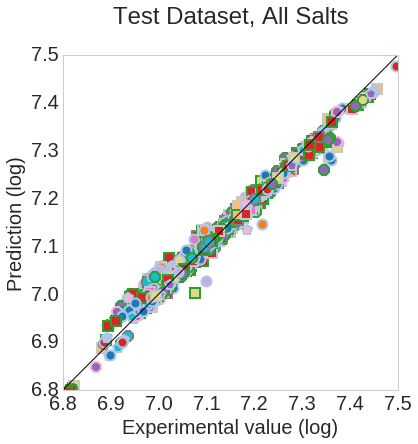

In [41]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_test)):
        catIndex = salty.checkName(catlist[i],index=True)[1]
        aniIndex = salty.checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
        
    scatter_this = ax2        
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(6.8,7.5,0.0001),np.arange(6.8,7.5,0.0001),color = 'black')
    ax2.axis([6.8,7.5,6.8,7.5])
    plt.title('Test Dataset, All Salts', y=1.08)
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()
fig.savefig(filename='../webapp/salty_web_app/collection/static/images/Test_Dataset_All_Salts.eps'\
            , bbox_inches='tight', format='eps')    

In [ ]:
["Temperature_K" , "Pressure_kPa", "Density_kg/m"]
X=Y_test
Y=model.predict(X_test)
to_save=pd.DataFrame(np.transpose([X,Y,labels,T,P]),columns=["Density_kg/m, Experimental",\
        "Density_kg/m, Prediction", "Salt Name", "Temperature_K" , "Pressure_kPa"])

In [ ]:
pd.DataFrame.to_csv(to_save, path_or_buf='../salty/data/data_2_d3_Press_Temp.csv', index=False)

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

In [5]:
####Create dataset according to LASSO selected features
select_score = np.load("LASSOSelectionScoresAllSalts.npy")
select_deslist = np.load("LASSOSelectionListAllSalts.npy")
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False)
avg_selected_features=34
df = df.iloc[:avg_selected_features]

datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)
atadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 
# datadf = datadf.loc[datadf["NAME_CAT"] != "1-ethyl-3-methylimidazolium"] #create subset

datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
datadf = datadf.drop("salt_name",1)

to_add=[]
for i in range(len(df)):
    to_add.append(df.index[i])
to_add.append("Density_kg/m")
cols = [col for col in datadf.columns if col in to_add]
data = datadf[cols]
        

data=np.array(data)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))


In [6]:
###optimization w/ 100 nodes in hidden layer
model = MLPRegressor(activation='tanh', alpha=0.00001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=100000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

model.fit(X_train,Y_train)

MLPRegressor(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=100000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

user has queried with a name
your query has returned CCN1C=C[N+](=C1)C
user has queried with a name
your query has returned [B-](F)(F)(F)F
user has queried with a name
your query has returned CCN1C=C[N+](=C1)C
user has queried with a name
your query has returned F[P-](F)(F)(F)(F)F
user has queried with a name
your query has returned CCCCCCN1C=C[N+](=C1)C
user has queried with a name
your query has returned [Cl-]
user has queried with a name
your query has returned CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC
user has queried with a name
your query has returned [Cl-]
user has queried with a name
your query has returned CCCCCCN1C=C[N+](=C1)C
user has queried with a name
your query has returned C(#N)[N-]C#N
user has queried with a name
your query has returned CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC
user has queried with a name
your query has returned [Cl-]
user has queried with a name
your query has returned CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC
user has queried with a name
your query has

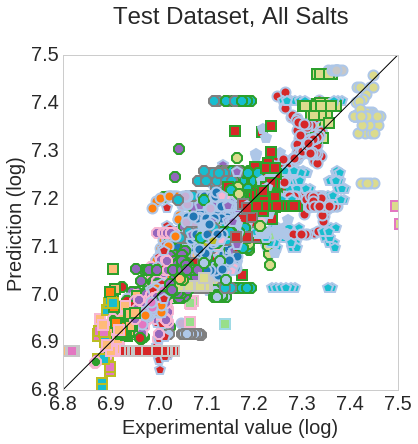

In [7]:
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_train)):
        catIndex = salty.checkName(catlist[i],index=True)[1]
        aniIndex = salty.checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
        
    scatter_this = ax2        
    for i in range(len(X_train)):
        ax2.plot(Y_train[i],model.predict(X_train[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(6.8,7.5,0.0001),np.arange(6.8,7.5,0.0001),color = 'black')
    ax2.axis([6.8,7.5,6.8,7.5])
    plt.title('Test Dataset, All Salts', y=1.08)
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()

fig.savefig(filename='../webapp/salty_web_app/collection/static/images/NN_Test_Dataset_All_Salts.eps', bbox_inches='tight', format='eps')    